In [299]:
# CLASSES
# Yandex DataLoader 

from datetime import datetime
import os
import dgl
import numpy as np
import torch 
import networkx as nx
from torch.nn import functional as F
import pandas as pd

class YandexDataLoader():
    def __init__(self, cur_dataset) -> None:
        data = np.load(os.path.join('/home/hwiric/2024/2024_filtered_heterophily_graph_data_test/yandex/data', 
                                    f'{cur_dataset.replace("-", "_")}.npz'))
        node_features = torch.tensor(data['node_features'])
        labels = torch.tensor(data['node_labels'])
        edges = torch.tensor(data['edges'])

        graph = dgl.graph((edges[:, 0], edges[:, 1]), num_nodes=len(node_features), idtype=torch.int)

        # if 'directed' not in cur_dataset:
        #     graph = dgl.to_bidirected(graph)

        # if add_self_loops:
        # 모두 self_loops를 추가한다고 가정함
        # graph = dgl.add_self_loop(graph)  # 논문에 제시된 값은 self loop 추가하기 전임

        num_classes = len(labels.unique())
        num_targets = 1 if num_classes == 2 else num_classes
        if num_targets == 1:
            labels = labels.float()

        train_masks = torch.tensor(data['train_masks'])
        val_masks = torch.tensor(data['val_masks'])
        test_masks = torch.tensor(data['test_masks'])

        train_idx_list = [torch.where(train_mask)[0] for train_mask in train_masks]
        val_idx_list = [torch.where(val_mask)[0] for val_mask in val_masks]
        test_idx_list = [torch.where(test_mask)[0] for test_mask in test_masks]

        self.name = cur_dataset
        self.graph = graph
        self.node_features = node_features
        self.labels = labels

        self.train_idx_list = [train_idx for train_idx in train_idx_list]
        self.val_idx_list = [val_idx for val_idx in val_idx_list]
        self.test_idx_list = [test_idx for test_idx in test_idx_list]
        self.num_data_splits = len(train_idx_list)
        self.cur_data_split = 0

        self.num_node_features = node_features.shape[1]
        self.num_targets = num_targets

        self.loss_fn = F.binary_cross_entropy_with_logits if num_targets == 1 else F.cross_entropy
        self.metric = 'ROC AUC' if num_targets == 1 else 'accuracy'
    
    def save_dgl_to_nx(self):
        nodes_id = self.graph.nodes().numpy()
        edges_src = self.graph.edges()[0].numpy()
        edges_dst = self.graph.edges()[1].numpy()
        nodes_features = self.node_features.numpy()
        nodes_labels = self.labels.numpy()

        edges = np.array(list(zip(edges_src, edges_dst)))
        src, dst = edges[0]

        G = nx.DiGraph().to_undirected()
        for node_id in nodes_id:
            node_id = int(node_id)
            G.add_node(node_id, features=nodes_features[node_id], label=nodes_labels[node_id])
        for edge in edges:
            src, dst = edge
            G.add_edge(int(src), int(dst))
        
        return G


In [300]:
# FUNCTIONS

from collections import defaultdict
import numpy as np 
import itertools
from collections import defaultdict
import math


def calc_edge_homophily(ydl):   # yandex_dataloader
    src = ydl.graph.edges()[0].numpy()
    dst = ydl.graph.edges()[1].numpy()
    pairs = list(zip(src, dst))
    labels = ydl.labels.numpy()

    homophily_count = 0
    for pair in pairs:
        u, v = pair
        if labels[u] == labels[v]:
            homophily_count += 1

    edge_homophily = homophily_count / len(src)
    return edge_homophily


def calc_adjusted_homophily(ydl):  # yandex_dataloader
    label_degree_cnt = defaultdict(int)
    labels = ydl.labels.numpy()

    for node in range(len(labels)):
        label = labels[node]
        degree = (ydl.graph.in_degrees(node) + ydl.graph.out_degrees(node))
        label_degree_cnt[label] += degree  # D_k

    total = 0
    edges_cnt = len(ydl.graph.edges()[0])
    edges_cnt = (2 * edges_cnt) * (2 * edges_cnt)

    for degree_cnt in label_degree_cnt.values():
        degree_cnt = degree_cnt * degree_cnt
        total += (degree_cnt / edges_cnt)

    edge_hm = calc_edge_homophily(ydl)
    adjusted_homophily = (edge_hm - total) / (1.0 - total)
    return adjusted_homophily


def get_p_bar_k(ydl):
    labels = ydl.labels
    edges_num = len(ydl.graph.edges()[0])
    nodes_num = len(labels)
    degree_dict = defaultdict(int)
    norm_degree_dict = defaultdict(int)

    for node in range(nodes_num):
        label = labels[node].item()
        degrees = ydl.graph.in_degrees(node) + ydl.graph.out_degrees(node)
        degree_dict[label] += degrees
    for label, degree in degree_dict.items():
        norm_degree_dict[label] = degree / (2 * edges_num)
    
    return norm_degree_dict


def get_p_c1_and_c2(ydl):
    unique_labels = np.unique(ydl.labels)
    unq_labels_product = list(itertools.product(unique_labels, repeat=2))

    src = ydl.graph.edges()[0].numpy()
    dst = ydl.graph.edges()[1].numpy()
    src_labels = []
    dst_labels = []
    
    edges_num = len(src)

    for v in src:
        src_labels.append(ydl.labels[v].item())
    for v in dst:
        dst_labels.append(ydl.labels[v].item())

    edge_label_pairs = list(zip(src_labels, dst_labels))
    label_pairs_dict = defaultdict(int)
    norm_label_pairs_dict = defaultdict(int)

    for product in unq_labels_product:
        c1, c2 = product
        for edge_label_pair in edge_label_pairs:
            y_u, y_v = edge_label_pair
            if y_u == c1 and y_v == c2:
                label_pairs_dict[(c1, c2)] += 1
    for pair, cnt in label_pairs_dict.items():
        norm_label_pairs_dict[pair] = cnt / (edges_num)

    return norm_label_pairs_dict


def get_p_k(ydl):
    labels = list(ydl.labels.numpy())
    edges_num = len(ydl.graph.edges()[0])
    nodes_num = len(labels)
    label_dict = defaultdict(int)
    norm_label_dict = defaultdict(int)

    for label in np.unique(labels):
        label_dict[label] = labels.count(label)
    for label, cnt in label_dict.items():
        norm_label_dict[label] = cnt / nodes_num
    
    return norm_label_dict


def check_summation(norm_degree_dict, norm_label_dict, norm_label_pairs_dict):
    print(f'차수의 sum: {sum(norm_degree_dict.values())}')
    print(f'클래스 개수의 sum: {sum(norm_label_dict.values())}')
    print(f'클래스 페어의 sum: {sum(norm_label_pairs_dict.values())}')


def calc_label_information(ydl):
    numerator = 0
    denominator = 0

    norm_degree_dict = get_p_bar_k(ydl)
    norm_label_dict = get_p_k(ydl)
    norm_label_pairs_dict = get_p_c1_and_c2(ydl)

    # check_summation(norm_degree_dict, norm_label_dict, norm_label_pairs_dict)

    for c1_c2, p_c1_c2 in norm_label_pairs_dict.items():
        c1, c2 = c1_c2
        p_bar_c1 = norm_degree_dict[c1]
        p_bar_c2 = norm_degree_dict[c2]
        numerator += p_c1_c2 * math.log2(p_c1_c2 / (p_bar_c1 * p_bar_c2))
    for p_bar_c in norm_degree_dict.values():
        denominator += p_bar_c * math.log2(p_bar_c)

    label_information = - (numerator / denominator)

    return label_information



In [301]:
import pandas as pd

class DatasetStkatistics():
    def __init__(self, dataset_num_list) -> None:
            self.dataset_names = {0: 'roman-empire', 1: 'amazon-ratings', 2: 'minesweeper', 3: 'tolokers', 4: 'questions',
                                  5: 'squirrel', 6: 'squirrel-directed', 7: 'squirrel-filtered', 8: 'squirrel-filtered-directed',
                                  9: 'chameleon', 10: 'chameleon-directed', 11: 'chameleon-filtered', 12: 'chameleon-filtered-directed',
                                  13: 'actor', 14: 'texas', 15: 'texas-4-classes', 16: 'cornell', 17: 'wisconsin'
                                }
            self.set_statistics(dataset_num_list)
            self.df = self.get_dataframe()

    def set_statistics(self, dataset_num_list):
        statistics_dict = defaultdict()

        for name_num in dataset_num_list:  # [0,1,2,3,4,8,12]
            ydl = YandexDataLoader(dataset_names[name_num])
            statistics_dict[ydl.name] = {
                'nodes_num': len(ydl.labels),
                'edges_num': len(ydl.graph.edges()[0]),
                'features': ydl.num_node_features,
                'label_info': calc_label_information(ydl),
                'adj_homo': calc_adjusted_homophily(ydl),
                'edge_homo': calc_edge_homophily(ydl),
                }

        self.statistics_dict = statistics_dict
    
    def get_dataframe(self):
        value_list = []
        column_list = []
        index_list = []

        for dataset, statistics in self.statistics_dict.items():
            value_list.append(list(statistics.values()))
            index_list.append(dataset)
            if len(column_list) == 0:
                column_list = (list(statistics.keys()))
            
        df = pd.DataFrame(value_list, index=index_list, columns=column_list)
        
        return df

In [305]:
# MAIN

dataset_names = {0: 'roman-empire', 1: 'amazon-ratings', 2: 'minesweeper', 3: 'tolokers', 4: 'questions',
                5: 'squirrel', 6: 'squirrel-directed', 7: 'squirrel-filtered', 8: 'squirrel-filtered-directed',
                9: 'chameleon', 10: 'chameleon-directed', 11: 'chameleon-filtered', 12: 'chameleon-filtered-directed',
                13: 'actor', 14: 'texas', 15: 'texas-4-classes', 16: 'cornell', 17: 'wisconsin'
                }

ds = DatasetStatistics([0,1,2,3,4,8,12])  # [0,1,2,3,4,8,12]
df = ds.df.head(10)

In [335]:
df.head(10)

,nodes_num,edges_num,features,label_info,adj_homo,edge_homo
roman-empire,22662,32927,300,0.219708,-0.046758,0.046892
amazon-ratings,24492,93050,300,0.039846,0.140230,0.380376
minesweeper,10000,39402,7,0.000088,0.009365,0.682783
tolokers,11758,519000,10,0.006862,0.092584,0.594522
questions,48921,153540,301,0.002130,0.020672,0.839566
squirrel-filtered-directed,2223,65718,2089,0.018418,0.021588,0.217414
chameleon-filtered-directed,890,13584,2325,0.024086,0.044975,0.247423


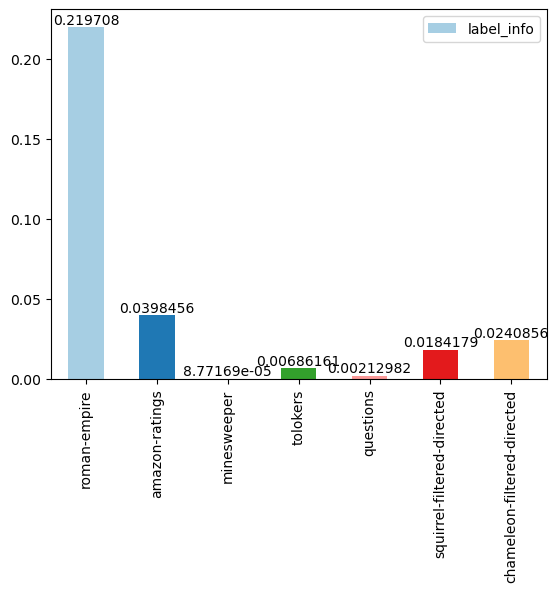

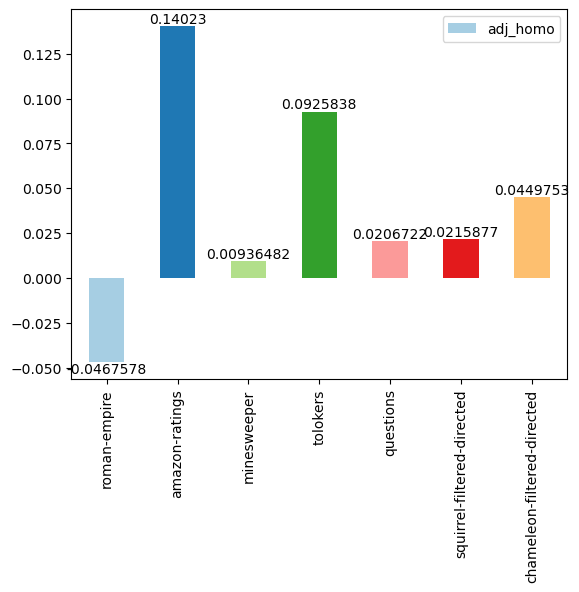

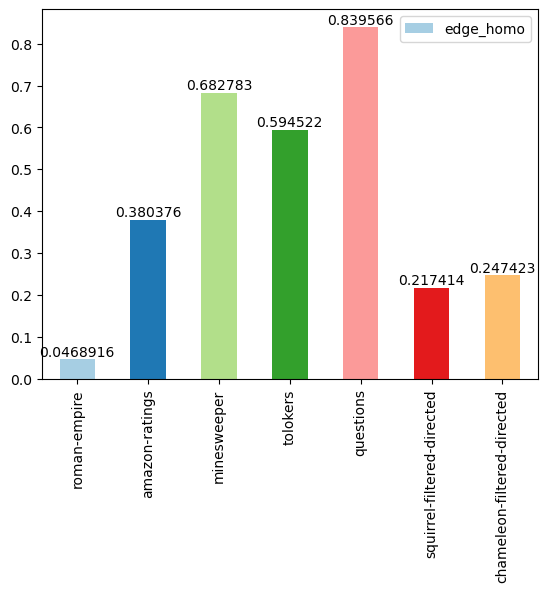

In [337]:
import matplotlib.pyplot as plt

ax1 = df.plot.bar(y='label_info', color=plt.cm.Paired(np.arange(len(df))))
ax2 = df.plot.bar(y='adj_homo', color=plt.cm.Paired(np.arange(len(df))))
ax3 = df.plot.bar(y='edge_homo', color=plt.cm.Paired(np.arange(len(df))))

for container in ax1.containers:
    ax1.bar_label(container, label_type='edge')
for container in ax2.containers:
    ax2.bar_label(container, label_type='edge')
for container in ax3.containers:
    ax3.bar_label(container, label_type='edge')